In [1]:
import utils
import warnings

warnings.filterwarnings('ignore')
utils.set_css_style('style.css')

# 5. Feature Engineering Techniques

Algorithms require features with some specific characteristic to work properly. Here, the need for feature engineering arises. Feature engineering efforts mainly have two goals:

* Preparing the proper input dataset, compatible with the machine learning algorithm requirements.
* Improving the performance of machine learning models.

> The features you use influence more than everything else the result. No algorithm alone, to my knowledge, can supplement the information gain given by correct feature engineering.
— Luca Massaron

According to a survey in Forbes, data scientists spend 80% of their time on data preparation.

<div class="item">
    <img src="figures/forbes.png" alt="forbes" width="600px"/>
    <span class="caption">Forbes Survey (<a href="https://www.forbes.com/sites/gilpress/2016/03/23/data-preparation-most-time-consuming-least-enjoyable-data-science-task-survey-says/">Source</a>)
    </span>
</div>

## 5.1. Data leakage

When training a machine learning model, we normally aim for the model that scores the highest on some metric, such as accuracy. Naturally, then, when we train a model that appears to score very well on our validation or test data-set, we select it as a well-performing model and productionize/finalize it.
However, have you ever encountered a situation in which a model performs well during testing, but fails to achieve the same level of performance during real-world usage? For example, has your model reached 99% accuracy during testing, but as soon as it is productionized and acts on real data, it fails to get anywhere near that level of performance?
Such a discrepancy between test performance and real-world performance is often explained by a phenomenon called **data leakage**.

Data leakage refers to a mistake make by the creator of a machine learning model in which they accidentally share information between the test and training data-sets. Typically, when splitting a data-set into testing and training sets, the goal is to ensure that no data is shared between the two. This is because the test set’s purpose is to simulate real-world, unseen data.


A very common error that people make is to leak information in the data **pre-processing step** of machine learning. It is essential that these transformations only have knowledge of the training set, even though they are applied to the test set as well. For example, if you decide that you want to run PCA as a pre-processing step, you should fit your PCA model on only the training set. Then, to apply it to your test set, you would only call its transform method (in the case of a `scikit-learn` model) on the test set. If, instead, you fit your pre-processor on the entire data-set, you will leak information from the test set, since the parameters of the pre-processing model will be fitted with knowledge of the test set.



In this section, we will use the loans prediction dataset provided in the following [competition](https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/) organized by Analytics Vidhya in order to explore some **popular feature engineering techniques**. 

In python, scikit-learn library has a pre-built functionality under `sklearn.preprocessing`. There are many more options for pre-processing which we’ll explore.

Now, lets get started by importing important packages and the data set.

In [34]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("data/data_loans.csv")

In [35]:
data.head()

,LoanID,Gender,Married,Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,CreditHistory,PropertyArea,LoanStatus
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [36]:
data.shape

(614, 13)

Let's seperate our features from our target variable and split the dataframe into 2 datasets.

In [37]:
y, X = data.pop("LoanStatus"), data
X.pop("LoanID")

# Split the 2 data into 2 sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print("Training set: ", X_train.shape, y_train.shape)
print("Testing set: ", X_test.shape, y_test.shape)

Training set:  (491, 11) (491,)
Testing set:  (123, 11) (123,)


## 5.2. Missing values imputation

Handling missing values is an essential preprocessing task that can drastically deteriorate your model when not done with sufficient care. Reasons for the missing values might be human errors, interruptions in the data flow, privacy concerns, and so on. Whatever is the reason, missing values affect the performance of the machine learning models.

A few questions should come up when handling missing values:

> Do I have missing values? How are they expressed in the data? Should I withhold samples with missing values? Or should I replace them? If so, which values should they be replaced with?

Some machine learning platforms automatically drop the rows which include missing values in the model training phase and it decreases the model performance because of the reduced training set size. On the other hand, most of the algorithms do not accept datasets with missing values and gives an error.

Before starting handling missing values it is important to identify the missing values and know with which value they are replaced. You should be able to find this out by combining the metadata information with exploratory analysis.
Once you know a bit more about the missing data you have to decide whether or not you want to keep entries with missing data.



Number of missing values in each column:

In [38]:
X_train.isna().sum(axis=0)

Gender                9
Married               2
Dependents           10
Education             0
SelfEmployed         24
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           17
LoanAmountTerm       10
CreditHistory        44
PropertyArea          0
dtype: int64

The most simple solution to the missing values is to drop the rows or the entire column. There is not an optimum threshold for dropping but you can use 50% as an example value and try to drop the rows and columns which have missing values with higher than this threshold. In our examples, we don't have such rows and columns.

The testing set should represent unseen data, that's why when doing feature engineering, we will apply exactly the same transformations applied to the training set. 

In [39]:
threshold = 0.5
# Dropping columns with missing value rate higher than threshold in the training set
X_train = X_train[X_train.columns[X_train.isnull().mean() < threshold]]
# Aligning the test dataset columns with the train dataset
X_train, X_test = X_train.align(X_test, join='left', axis=1)

# Dropping rows with missing value rate higher than threshold
X_train = X_train.loc[X_train.isnull().mean(axis=1) < threshold]
X_test = X_test.loc[X_test.isnull().mean(axis=1) < threshold]

In [40]:
print("Training set: ", X_train.shape, y_train.shape)
print("Testing set: ", X_test.shape, y_test.shape)

Training set:  (491, 11) (491,)
Testing set:  (123, 11) (123,)


### 5.2.1. Numerical imputation
Imputation is a more preferable option rather than dropping because it preserves the data size. However, there is an important selection of what you impute to the missing values. 

Except for the case of having a default value for missing values, a popular imputation method is to use the medians of the columns. As the averages of the columns are sensitive to the outlier values, while medians are more solid in this respect.


Columns with missing values:

In [41]:
# columns with missing values
missing_columns = X_train.isna().sum()[X_train.isna().sum()>0].index.values.tolist()
missing_columns

['Gender',
 'Married',
 'Dependents',
 'SelfEmployed',
 'LoanAmount',
 'LoanAmountTerm',
 'CreditHistory']

let's plot a histogram of our numerical columns 

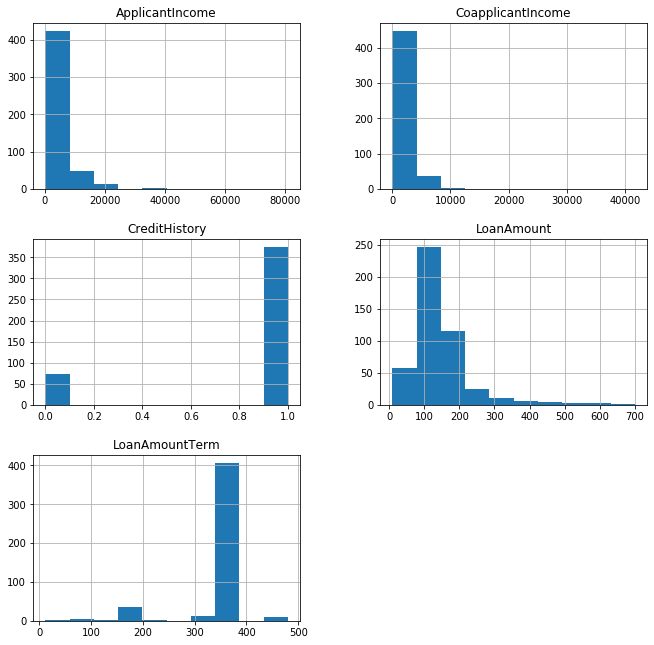

In [42]:
# numerical columns
numeric_columns = X_train.dtypes[((X_train.dtypes=="float64")|(X_train.dtypes=="int64"))].index.values.tolist()

#plot a histogram of numerical columns with missing values
X_train[numeric_columns].hist(figsize=[11,11]);

Let's impute missing values in column `CreditHistory` with 1, and the 2 other numercial columns `LoanAmount` & `LoanAmountTerm` with the median.

In [43]:
from sklearn.impute import SimpleImputer

# Let's define a constant imputer in order to impute missing values in CreditHistory with 1.
imp_constant = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=1)
X_train[["CreditHistory"]] = imp_constant.fit_transform(X_train[["CreditHistory"]])
X_test[["CreditHistory"]] = imp_constant.transform(X_test[["CreditHistory"]])

# Let's define an imputer with median strategy in order to impute missing values in LoanAmount and LoanAmountTerm
cols = ["LoanAmount", "LoanAmountTerm"]
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
X_train[cols] = imp_median.fit_transform(X_train[cols])
X_test[cols] = imp_median.transform(X_test[cols])

Number of missing values in each column:

In [44]:
X_train.isna().sum()

Gender                9
Married               2
Dependents           10
Education             0
SelfEmployed         24
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
LoanAmountTerm        0
CreditHistory         0
PropertyArea          0
dtype: int64

### 5.2.2. Categorical imputation

Replacing the missing values with the maximum occurred value in a column is a good option for handling categorical columns. But if you think the values in the column are distributed uniformly and there is not a dominant value, imputing a category like “Other” might be more sensible, because in such a case, your imputation is likely to converge a random selection.



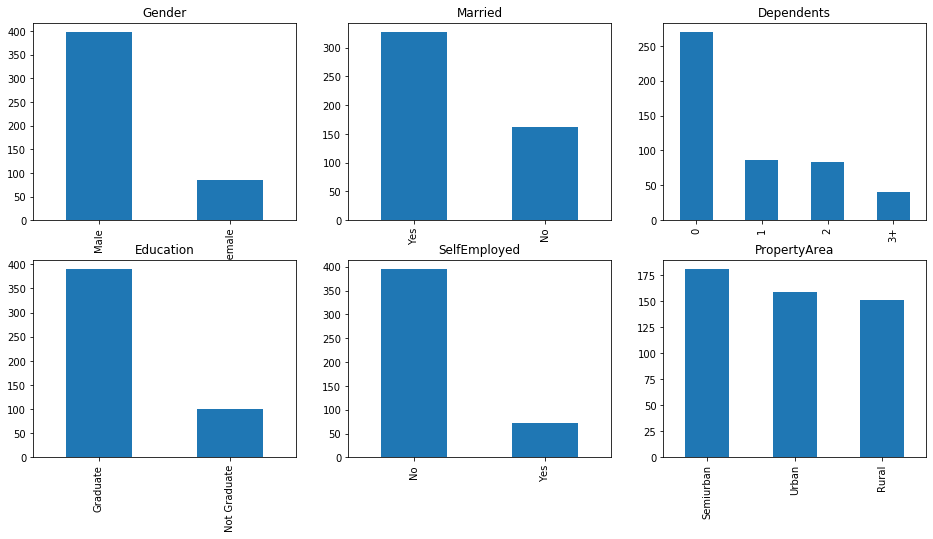

In [45]:
categorical_columns = X_train.dtypes[((X_train.dtypes=="object"))].index.values.tolist()

fig, ax = plt.subplots(2, int(len(categorical_columns)/2), figsize=(16,8))
for i, categorical_col in enumerate(X_train[categorical_columns]):
    X_train[categorical_col].value_counts().plot("bar", ax=sum(ax.tolist(), [])[i]).set_title(categorical_col)
fig.show()

Let's impute the missing values in the columns `Married`,` Sex`, `Dependent` with the dominant value (most frequent), while in the column` SelfEmployed` with a constant "UNK".

In [46]:
# Imputing missing values in columns Married, Gender, Dependents with the dominant (most frequent) value
cols = ["Married", "Gender", "Dependents"]
imp_most_frequent = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X_train[cols] = imp_most_frequent.fit_transform(X_train[cols])
X_test[cols] = imp_most_frequent.transform(X_test[cols])

# Imputing column column SelfEmployed with a constant 'UNK'
imp_constant = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='UNK')
X_train[["SelfEmployed"]] = imp_constant.fit_transform(X_train[["SelfEmployed"]])
X_test[["SelfEmployed"]] = imp_constant.transform(X_test[["SelfEmployed"]])

Number of missing values in each column:

In [47]:
X_train.isna().sum()

Gender               0
Married              0
Dependents           0
Education            0
SelfEmployed         0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
LoanAmountTerm       0
CreditHistory        0
PropertyArea         0
dtype: int64

## 5.3. Scaling

In most cases, the numerical features of the dataset do not have a certain range and they differ from each other. In real life, it is nonsense to expect age and income columns to have the same range. But from the machine learning point of view, how can these two columns be compared?

Scaling solves this problem. The continuous features become identical in terms of the range, after a scaling process. This process is not mandatory for many algorithms, but it might be still nice to apply. However, the algorithms based on distance calculations such as k-NN or k-Means need to have scaled continuous features as model input.

**We will talk more about the importance of scaling in the next chapter.**

`sklearn` provides a tool `MinMaxScaler` that will scale down all the features between 0 and 1. Mathematical formula for MinMaxScaler is:

\begin{equation}
{\displaystyle x'={\frac {x-{\text{min}}(x)}{{\text{max}}(x)-{\text{min}}(x)}}}
\end{equation}

We will only scale the numerical columns.

In [48]:
from sklearn.preprocessing import MinMaxScaler
mmc = MinMaxScaler()
scaled_columns = [x for x in numeric_columns if x != 'CreditHistory']

X_train[scaled_columns] = mmc.fit_transform(X_train[scaled_columns])
X_test[scaled_columns] = mmc.transform(X_test[scaled_columns])

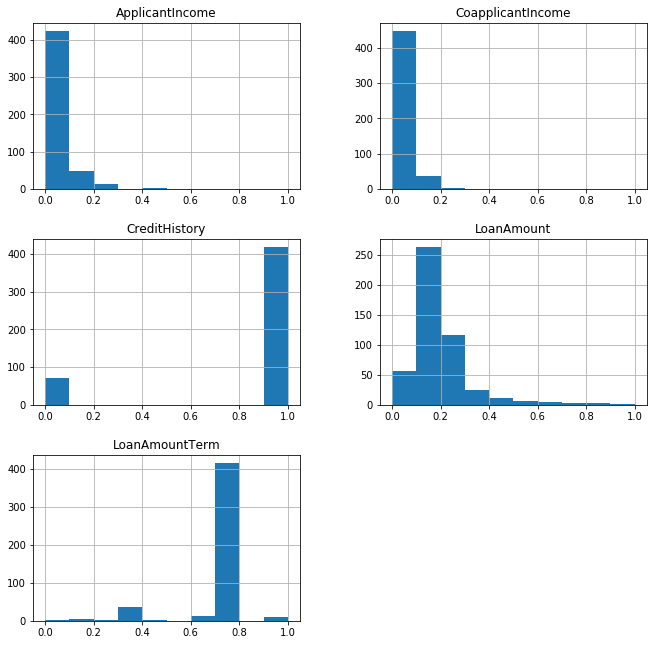

In [49]:
#plot a histogram of numerical columns with missing values
X_train[numeric_columns].hist(figsize=[11,11]);

## 5.4. Label encoding

In previous sections, we did the pre-processing for continuous numeric features. But, our data set has other features too such as Gender, Married, Dependents, SelfEmployed and Education. All these categorical features have string values. And algorithms work with numbers!

If we feed the categorical features to a logistic regression model for example, we get an error saying that it cannot convert string to float. So, what’s actually happening here is that most learners in `sklearn` needs numeric arrays. Features having string values cannot be handled automatically.

This encoding type is better for **ordinal categorical data** and if the **number of categorical features in the dataset** is huge, you may often use label encoding.

`Sklearn` provides a very efficient tool for encoding the levels of a categorical features into numeric values. `LabelEncoder` encode labels with value between 0 and n_classes-1.

In [50]:
X_train.head()

,Gender,Married,Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,CreditHistory,PropertyArea
291,Male,Yes,2,Graduate,No,0.052566,0.000000,0.170767,0.74359,0.0,Semiurban
507,Male,No,0,Graduate,No,0.042461,0.000000,0.125904,0.74359,1.0,Urban
328,Female,Yes,0,Graduate,No,0.051738,0.058824,0.146165,0.74359,1.0,Urban
609,Female,No,0,Graduate,No,0.034014,0.000000,0.089725,0.74359,1.0,Rural
69,Female,No,0,Graduate,No,0.051330,0.000000,0.183792,0.74359,0.0,Semiurban


Let's label encode binary catagorical columns only:

In [51]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Iterating over all the common columns in train and test
for col in ["Gender", "Married", "Education"]:
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

In [52]:
X_train.head()

,Gender,Married,Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,CreditHistory,PropertyArea
291,1,1,2,0,No,0.052566,0.000000,0.170767,0.74359,0.0,Semiurban
507,1,0,0,0,No,0.042461,0.000000,0.125904,0.74359,1.0,Urban
328,0,1,0,0,No,0.051738,0.058824,0.146165,0.74359,1.0,Urban
609,0,0,0,0,No,0.034014,0.000000,0.089725,0.74359,1.0,Rural
69,0,0,0,0,No,0.051330,0.000000,0.183792,0.74359,0.0,Semiurban


## 5.5. One-hot encoding

Depending on the data, label encoding introduces a new problem. For example, we have encoded a set of `Gender` into numerical data. This is actually categorical data and there is no relation, of any kind, between the rows.
The problem here is, since there are different numbers in the same column, the model will misunderstand the data and will be confused into thinking that there's some kind of order or hierarchy, 0 < 1 < 2. But this isn’t the case at all. To overcome this problem, we use One Hot Encoder.

We mainly use one hot encoding with **nominal data**.

One-hot encoding is one of the most common encoding methods in machine learning. This method spreads the values in a column to multiple flag columns and assigns 0 or 1 to them. These binary values express the relationship between grouped and encoded column.

This method changes your categorical data, which is challenging to understand for algorithms, to a numerical format and enables you to group your categorical data without losing any information. 

<div class="item">
    <img src="figures/one-hot.png" alt="one-hot" width="600px"/>
    <span class="caption">One hot encoding example on City column
    </span>
</div>

In `sklearn`, we can use the `OneHotEncoder` class which creates a binary column for each category and returns a sparse matrix or dense array (depending on the sparse parameter). 2 important parameters:

* **drop: ‘first’ or a array-like of shape (n_features,), default=None**

    Specifies a methodology to use to drop one of the categories per feature. This is useful in situations where perfectly collinear features cause problems, such as when feeding the resulting data into a neural network or an unregularized regression.
    
    
* **handle_unknown: {‘error’, ‘ignore’}, default=’error’**

    Whether to raise an error or ignore if an unknown categorical feature is present during transform (default is to raise). When this parameter is set to ‘ignore’ and an unknown category is encountered during transform, the resulting one-hot encoded columns for this feature will be all zeros. 

In [53]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(drop = None, handle_unknown='ignore', sparse=False)

# Define categorical to be one hot encoded
ohe_cols = ["Dependents", "SelfEmployed", "PropertyArea"]

# Encode categorical columns, and store results in a new dataframe
X_train_encoded = pd.DataFrame(ohe.fit_transform(X_train[ohe_cols]), index=X_train.index)
X_test_encoded = pd.DataFrame(ohe.transform(X_test[ohe_cols]), index=X_test.index)

# Retrieve encoded columns names
X_train_encoded.columns = ohe.get_feature_names(ohe_cols)
X_test_encoded.columns = ohe.get_feature_names(ohe_cols)

# Drop initial columns 
X_train.drop(ohe_cols ,axis=1, inplace=True)
X_test.drop(ohe_cols ,axis=1, inplace=True)

# Add encoded columns to initial dataset
X_train = pd.concat([X_train, X_train_encoded], axis=1)
X_test = pd.concat([X_test, X_test_encoded ], axis=1)

In [54]:
X_train.head()

,Gender,Married,Education,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,CreditHistory,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,SelfEmployed_No,SelfEmployed_UNK,SelfEmployed_Yes,PropertyArea_Rural,PropertyArea_Semiurban,PropertyArea_Urban
291,1,1,0,0.052566,0.000000,0.170767,0.74359,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
507,1,0,0,0.042461,0.000000,0.125904,0.74359,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
328,0,1,0,0.051738,0.058824,0.146165,0.74359,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
609,0,0,0,0.034014,0.000000,0.089725,0.74359,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
69,0,0,0,0.051330,0.000000,0.183792,0.74359,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## 5.6. Other feature engineering techniques & references

The aim of this section is to familiarize you with the basic feature engineering techniques and have a deeper understanding of the situations of where to apply those techniques.

These methods work because of the underlying assumptions of the algorithms. This is by no means an exhaustive list of the methods. Other type of preprocessing techniques include:

### 5.6.1. Handling outliers

Data outliers can spoil and mislead the training process resulting in longer training times, less accurate models and ultimately poorer results.

Before mentioning some techniques for how outliers can be handled, It's good to state that the best way to detect the outliers is to demonstrate the data visually. All other statistical methodologies are open to making mistakes, whereas visualizing the outliers might give a chance to take a decision with high precision.

There are many different methods of dealing with outliers, here are some popular techniques:

* **Univariate method**: This method looks for data points with extreme values on one variable.

    For more details about the statistical methods used for outlier detection, check [this blog](http://colingorrie.github.io/outlier-detection.html)


* **Multivariate method**: Here we look for unusual combinations on all the variables.

<div class="item">
    <img src="figures/multivariate-outlier-example.jpg" alt="multivariate-outlier-example" width="500px"/>
</div>

* **Minkowski error**: This method reduces the contribution of potential outliers in the training process.

    Unlike the univariate and multivariate methods, it doesn't detect and clean the outliers. Instead, it reduces the impact that outliers will have in the model.

    The Minkowski error is a loss index that is more insensitive to outliers than the standard mean squared error. The mean squared error raises each instance error to the square, making a too big contribution of outliers to the total error. The Minkowski error solves that by raising each instance error to a number smaller than 2, for instance 1.5. This reduces the contribution of outliers to the total error. 


### 5.6.2. Binning/Bucketing

Binning can be applied on both categorical and numerical data:


<div class="item">
    <img src="figures/binning.png" alt="binning" width="400px" style="padding:20px;"/>
</div>


If you choose to bucketize your numerical features, be clear about how you are setting the boundaries and which type of bucketing you’re applying:

* **Buckets with equally spaced boundaries**: the boundaries are fixed and encompass the same range (for example, 0-4 degrees, 5-9 degrees, and 10-14 degrees). Some buckets could contain many points, while others could have few or none.

* **Buckets with quantile boundaries**: each bucket has the same number of points. The boundaries are not fixed and could encompass a narrow or wide span of values. 

<div class="row">
  <div class="column">
    <img src="figures/bucketizing-1.svg" alt="bucketizing-1"/>
  </div>
  <div class="column">
     <img src="figures/bucketizing-2.svg" alt="bucketizing-2"/>
  </div>
</div>
    


Bucketing with equally spaced boundaries is an easy method that works for a lot of data distributions. For skewed data, however, try bucketing with quantile bucketing.

### 5.6.3. Log transform

Logarithm transformation is one of the most commonly used mathematical transformations in feature engineering. What are the benefits of log transform:

It helps to handle skewed data and after transformation, the distribution becomes more approximate to normal.
In most of the cases the magnitude order of the data changes within the range of the data. For instance, the difference between the ages of 15 and 20 is not equal to the ages 65 and 70. In terms of years, yes, they are identical, but for all other aspects, 5 years of difference in young ages mean a higher magnitude difference. This type of data comes from a multiplicative process and log transform normalizes the magnitude differences like that.

It also decreases the effect of the outliers, due to the normalization of magnitude differences and the model becomes more robust.

A critical note: The data you apply log transform must have only positive values, otherwise you receive an error. Also, you can add 1 to your data before transforming it. Thus, you ensure the output of the transformation to be positive.